# Infectious Disease Dynamics: Final Project

In [ ]:
import numpy as np
from scipy.special import logit
import matplotlib.pyplot as plt
from numpy.random import default_rng
from mcmc.sir_aug import sir_out
from mcmc.mcmc_aug import (
    run_one_timestep,
    initialize_array,
    calc_log_likelihood,
    proposal_draw,
    run_mcmc,
)
from mcmc.constants import (
    NEW_YORK_POP_1930,
    VERMONT_POP_1930
)

rng = default_rng(seed=42)

In [51]:
NEW_YORK_POP_1930*.00005

629.4033000000001

In [52]:
dt = 1/12 # time step in years

horrible_guess = -1e10

guess_beta = 5 / 250
guess_gamma = 1 / 250
guess_season = .99999
guess_peak = 3

guess_s_init_frac_ny = 0.95  # Initial susceptible fractions for New York
guess_i_init_frac_ny = .05  # Initial infected fractions for New York
guess_rho_ny = 0.25  # guess for rho the reporting rate for New York
guess_mu_ny = (206_194/NEW_YORK_POP_1930) * dt  # guess for mu (death rate) for New York
guess_sigma_ny = (2_203_958/NEW_YORK_POP_1930) * dt
# guess_sigma_ny = (500_000/NEW_YORK_POP_1930) * dt  # sigma (birth rate) for New York

# Initial susceptible and infected fractions for Vermont
guess_s_init_frac_vt = 0.95
guess_i_init_frac_vt = .05
guess_rho_vt = 0.25  # guess for rho the reporting rate for Vermont
guess_mu_vt = (25/1000) * dt  # guess for mu (death rate) for Vermont
guess_sigma_vt = (44.3/1000) * dt # sigma (birth rate) for Vermont alternative
# guess_sigma_vt = (29/1000) * dt  # sigma (birth rate) for Vermont

init_guess_params = np.array([
    np.log(guess_beta),
    np.log(guess_gamma),
    logit(guess_season),
    logit(guess_peak / 12),

    logit(guess_s_init_frac_ny),
    logit(guess_i_init_frac_ny / (1 - guess_s_init_frac_ny)),
    logit(guess_rho_ny),
    np.log(guess_mu_ny),
    np.log(guess_sigma_ny),

    logit(guess_s_init_frac_vt),
    logit(guess_i_init_frac_vt / (1 - guess_s_init_frac_vt)),
    logit(guess_rho_vt),
    np.log(guess_mu_vt),
    np.log(guess_sigma_vt)
])


In [53]:
import pandas as pd

obs_cases_df = pd.read_csv(
    "data/measles_in_new_york_and_vermont_1930_1939.csv"
)
obs_cases_df.columns

Index(['month_start', 'new_york_obs_cases', 'vermont_obs_cases'], dtype='object')

In [54]:
observed_data = obs_cases_df[["new_york_obs_cases", "vermont_obs_cases"]].values
num_time_steps = observed_data.shape[0]

In [55]:
# Run the simulation
data_both = sir_out(init_guess_params, rng=rng, num_time_steps=num_time_steps)

In [56]:
data_both[0].shape

(121, 7)

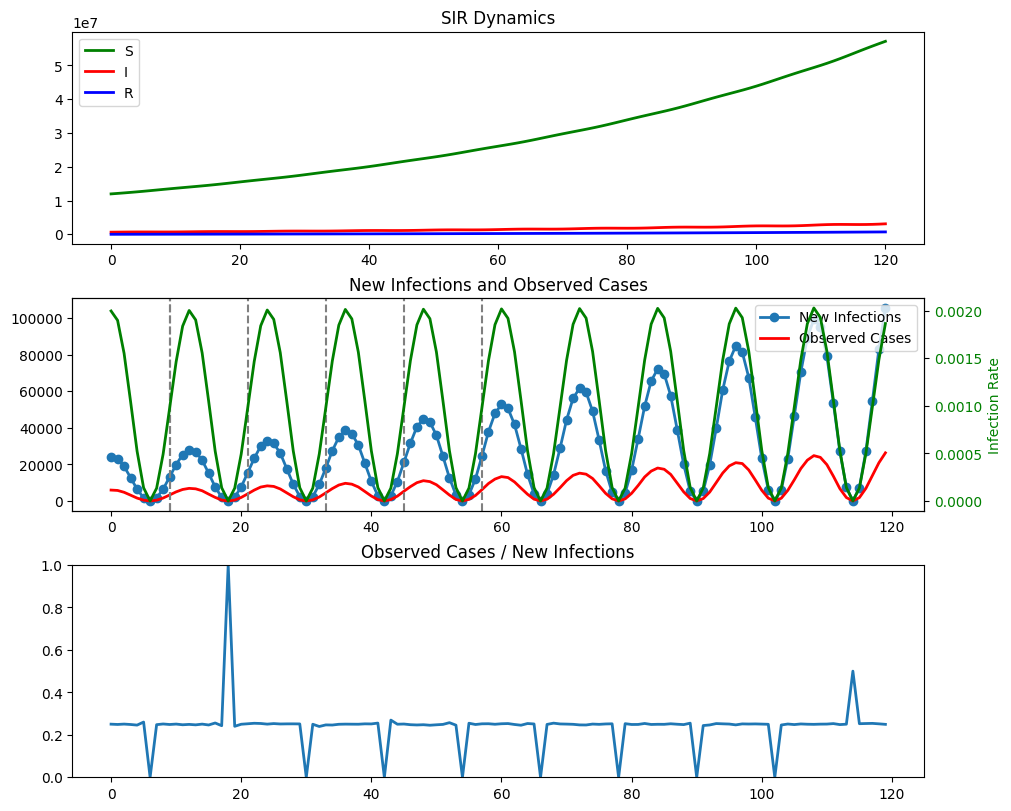

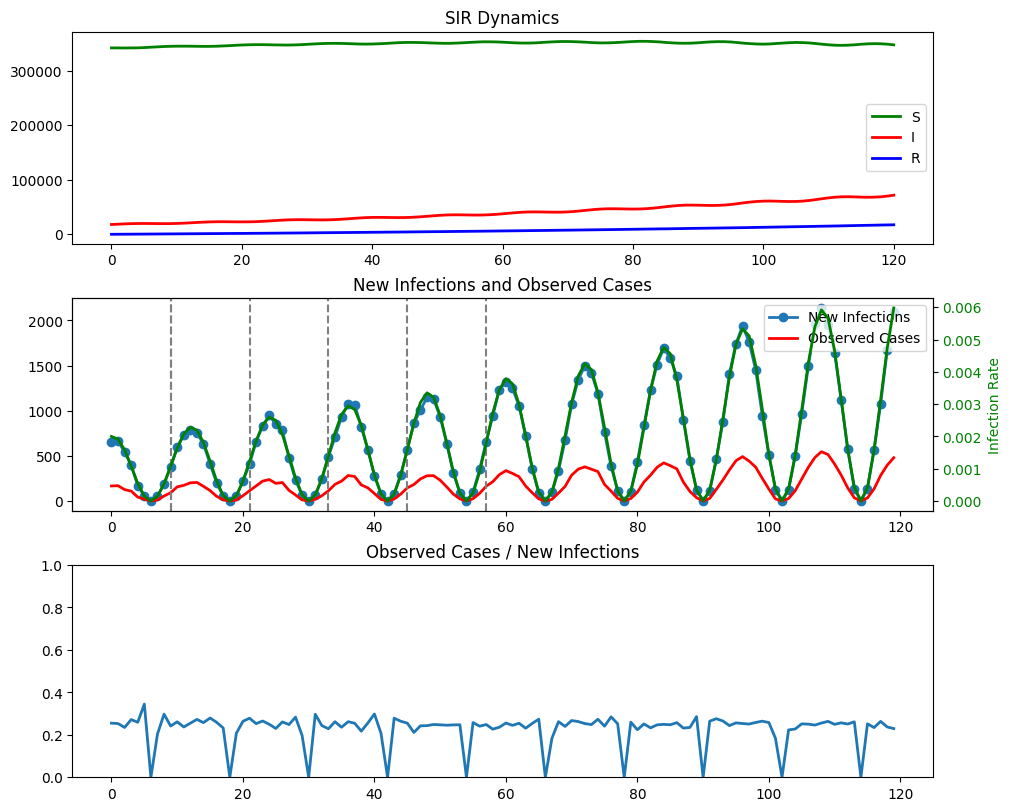

In [57]:
def helper_plot_func(data: np.ndarray):
    # Set up 3 vertically stacked plots with consistent margins
    fig, axs = plt.subplots(3, 1, figsize=(10, 8), constrained_layout=True)

    # First plot: S, I, R over time
    axs[0].plot(data[:, 0], label='S', color='green', linewidth=2)
    axs[0].plot(data[:, 1], label='I', color='red', linewidth=2)
    axs[0].plot(data[:, 2], label='R', color='blue', linewidth=2)
    # axs[0].set_ylim(0, np.nanmax(data[:, 0:3]))
    axs[0].set_title("SIR Dynamics")
    axs[0].legend()

    # Second plot: New Infections and Observed Cases
    axs[1].plot(data[:, 3], marker='o', linestyle='-', linewidth=2, label='New Infections')
    axs[1].plot(data[:, 5], color='red', linewidth=2, label='Observed Cases')

    axs[1].axvline(x=9, linestyle='--', color='gray')  # equivalent to abline at v=9,21,33,45,57
    for x in range(9, 9 + 12 * 4 + 1, 12):
        axs[1].axvline(x=x, linestyle='--', color='gray')

    axs[1].set_title("New Infections and Observed Cases")
    axs[1].legend(loc='upper right')

    # Overlay the infection rate curve from column 6
    ax2 = axs[1].twinx()
    ax2.plot(data[:, 6], color='green', linewidth=2, label='Infection Rate')

    ax2.set_ylabel("Infection Rate", color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    # Third plot: Observed / New Infections (reporting rate estimate)
    ratio = np.divide(data[:, 5], data[:, 3], out=np.zeros_like(data[:, 5]), where=data[:, 3]!=0)

    axs[2].plot(ratio, linewidth=2)
    axs[2].set_ylim(0, 1)
    axs[2].set_title("Observed Cases / New Infections")

    plt.show()


for data in data_both:
    helper_plot_func(data)

In [9]:
init_guess_params

array([-3.91202301, -5.52146092, 11.51291546, -1.09861229,  2.94443898,
       34.79089042, -1.09861229, -6.59659368, -4.22740104,  2.94443898,
       34.79089042, -1.09861229, -6.1737861 , -5.60167725])

In [10]:
len(init_guess_params)

14

In [11]:
proposal_standard_dev = np.array([
    0.05, 0.05, 0.02, 0.02, # beta, gamma, season, peak
    0.05, 0.05, 0.01, 0.01, 0.01, # s_init_ny, i_init_ny, rho_ny, mu_ny (death), sigma_ny (birth)
    0.05, 0.05, 0.01, 0.01, 0.01, # s_init_vt, i_init_vt, rho_vt, mu_vt (death), sigma_vt (birth)
])
# proposal_standard_dev = np.array([
#     10, 10, 10, 10, # beta, gamma, season, peak
#     10, 10, 10, 10, 10, # s_init_ny, i_init_ny, rho_ny, mu_ny (death), sigma_ny (birth)
#     10, 10, 10, 10, 10, # s_init_vt, i_init_vt, rho_vt, mu_vt (death), sigma_vt (birth)
# ])
num_params = len(init_guess_params)


current_params = init_guess_params + proposal_draw(
    proposal_standard_dev=proposal_standard_dev,
    rng=rng,
)

current_run = calc_log_likelihood(
    params=current_params,
    observed_data=observed_data,
    num_time_steps=num_time_steps,
    rng=rng,
)
current_log_likelihood = current_run[0]

try_a_bunch = 100
guess_attempt = 1

while guess_attempt < try_a_bunch and current_log_likelihood <= horrible_guess:
    current_params = proposal_draw(proposal_standard_dev, rng=rng)
    current_run = calc_log_likelihood(current_params, observed_data, num_time_steps=num_time_steps, rng=rng)
    current_log_likelihood = current_run[0]
    guess_attempt += 1

current_latent = current_run[1]

chain = current_params.reshape((num_params, 1))
latents = [current_latent]
accept_chain = [0]  # Use list to accumulate
all_steps = {
    "chain": chain,
    "latents": latents,
    "accept_chain": accept_chain,
    "log_likelihood": [current_log_likelihood],
    "current_latent": current_latent,
}

In [12]:
# Running MCMC steps
all_steps = run_mcmc(
    n_steps=500,
    all_steps=all_steps,
    proposal_standard_dev=proposal_standard_dev,  # Proposal SDs, adjust as needed
    # proposal_standard_dev=np.ones(num_params) * 25,
    observed_data=observed_data,
    num_time_steps=num_time_steps,
    rng=rng,
)

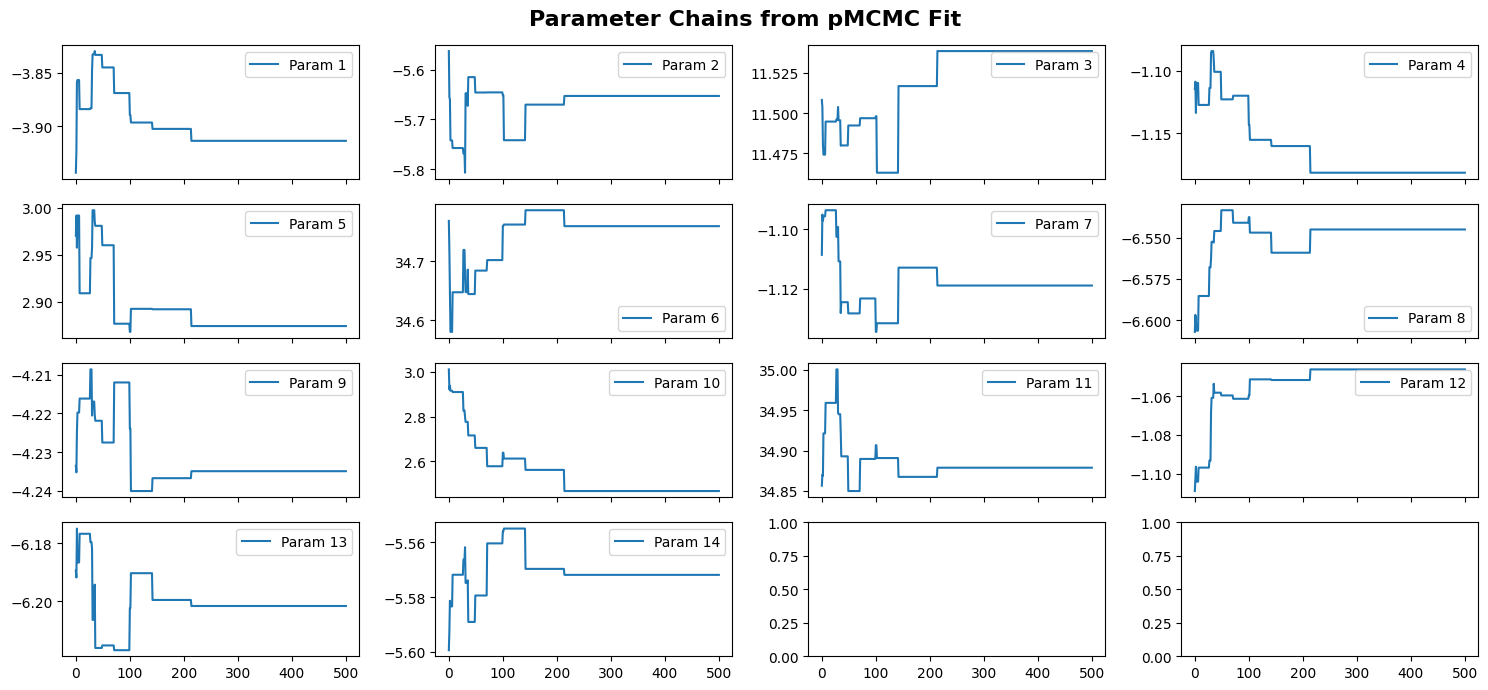

In [33]:
# Plotting parameter chains with target lines
fig, axs = plt.subplots(4, 4, figsize=(15, 7), sharex=True)  # 3 rows, 4 cols layout
axs = axs.flatten()

for par_num in range(num_params):
    # ylim = (np.min(all_steps["chain"][par_num, :]), np.max(all_steps["chain"][par_num, :]))
    axs[par_num].plot(all_steps["chain"][par_num, :], label=f"Param {par_num+1}")
    # axs[par_num].axhline(target_vector[par_num], color='red', linewidth=2, label="Target")
    # axs[par_num].set_ylim(ylim)
    axs[par_num].legend()

plt.suptitle("Parameter Chains from pMCMC Fit", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig("visuals/pmcmc_parameter_chains.png", dpi=300)
plt.show()


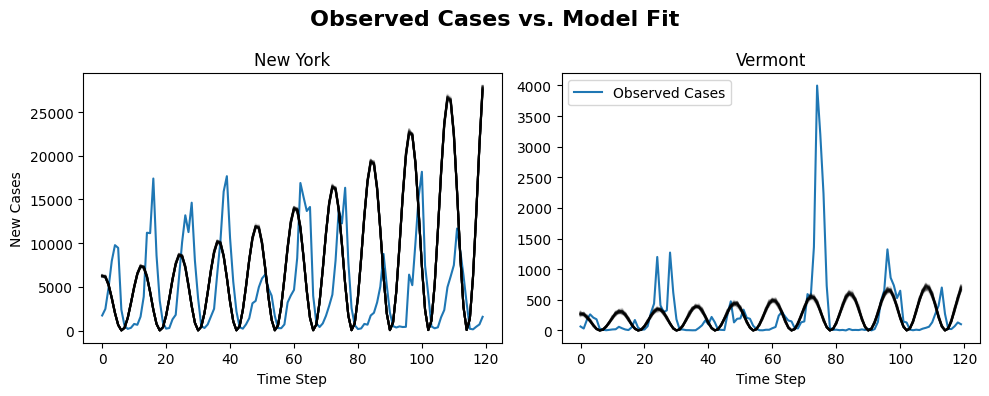

In [48]:
# Plot observed data
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].plot(observed_data[:, 0], label="Observed Cases")  # data[,6] in R is data[:,5] in Python (0-indexed)
ax[1].plot(observed_data[:, 1], label="Observed Cases")  # data[,6] in R is data[:,5] in Python (0-indexed)

out_guess = sir_out(init_guess_params, rng=rng, num_time_steps=num_time_steps)

# ax[0].plot(out_guess[0][:, 5], label="Init Guess")  # black with alpha=0.1
# ax[1].plot(out_guess[1][:, 5], label="Init Guess")  # black with alpha=0.1

for _ in range(40):
    out = sir_out(all_steps["chain"][:, -1], rng=rng, num_time_steps=num_time_steps)
    ax[0].plot(out[0][:, 5], color=(0, 0, 0, 0.1))  # black with alpha=0.1
    ax[1].plot(out[1][:, 5], color=(0, 0, 0, 0.1))  # black with alpha=0.1

ax[0].set_ylabel("New Cases")
ax[0].set_xlabel("Time Step")
ax[1].set_xlabel("Time Step")

ax[0].set_title("New York")
ax[1].set_title("Vermont")
plt.suptitle("Observed Cases vs. Model Fit", fontsize=16, fontweight='bold')
plt.legend()
plt.tight_layout()
plt.savefig("visuals/measles_ny_vt_obs_cases_model_fit.png", dpi=300)
plt.show()

In [36]:
from scipy.special import expit

def transform_params(params: np.ndarray) -> np.ndarray:
    """
    Transform parameters from logit/log scale to original scale.
    """
    transformed = np.copy(params)
    transformed[0] = np.exp(transformed[0])  # beta
    transformed[1] = np.exp(transformed[1])  # gamma
    transformed[2] = expit(transformed[2])  # season
    transformed[3] = expit(transformed[3]) * 12  # peak (in months)
    transformed[4] = expit(transformed[4])  # s_init_ny
    transformed[5] = expit(transformed[5]) * (1 - expit(transformed[4]))  # i_init_ny
    transformed[6] = expit(transformed[6])  # rho_ny
    transformed[7] = np.exp(transformed[7])  # mu_ny
    transformed[8] = np.exp(transformed[8])  # sigma_ny
    transformed[9] = expit(transformed[9])  # s_init_vt
    transformed[10] = expit(transformed[10]) * (1 - expit(transformed[9]))  # i_init_vt
    transformed[11] = expit(transformed[11])  # rho_vt
    transformed[12] = np.exp(transformed[12])  # mu_vt
    transformed[13] = np.exp(transformed[13])  # sigma_vt
    # Ensure the transformed parameters are in the correct range

    return transformed

In [41]:
transform_params(all_steps["chain"][:, -1])

array([1.99681650e-02, 3.50677796e-03, 9.99990251e-01, 2.81780572e+00,
       9.46545421e-01, 2.79580096e-01, 2.46223570e-01, 1.43721803e-03,
       1.44804246e-02, 9.21827762e-01, 2.84585622e-01, 2.59942816e-01,
       2.02628539e-03, 3.80337045e-03])

In [58]:
for value in transform_params(all_steps["chain"][:, -1]):
    print(round(value, 5))

0.01997
0.00351
0.99999
2.81781
0.94655
0.27958
0.24622
0.00144
0.01448
0.92183
0.28459
0.25994
0.00203
0.0038
